In [160]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.models import Sequential
from keras.layers import Dense, Dropout
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re

In [187]:
# data_game_info = pd.read_csv('../archive/metacritic_game_info.csv')
data = pd.read_csv('../archive/metacritic_game_user_comments.csv')

In [188]:
print(f"Nombre de lignes : {data.shape[0]}")
print(f"Nombre de colonnes : {data.shape[1]}")

Nombre de lignes : 283983
Nombre de colonnes : 6


In [202]:
nan_rows = data[data.isnull().any(axis=1)]
print(f"\nNombre total de lignes avec des NaN : {nan_rows.shape[0]}")


Nombre total de lignes avec des NaN : 27


In [162]:
# Nettoyage des données
# Suppression des colonnes inutiles et des valeurs manquantes
filter_data = data[['Userscore', 'Comment']]
filter_data = filter_data.dropna()

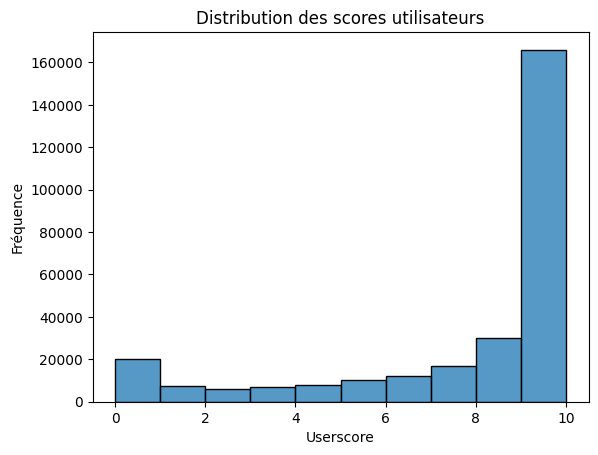

In [200]:
# Histogramme des scores utilisateurs
sns.histplot(filter_data['Userscore'], bins=10)
plt.title("Distribution des scores utilisateurs")
plt.xlabel("Userscore")
plt.ylabel("Fréquence")
plt.show()

In [189]:
print(f"Nombre de lignes : {filter_data.shape[0]}")
print(f"Nombre de colonnes : {filter_data.shape[1]}")

Nombre de lignes : 283960
Nombre de colonnes : 3


In [163]:
# Conversion des scores utilisateurs en classes de sentiment
def determiner_sentiment(score):
    if score >= 6:
        return 2
    elif score <= 3:
        return 0
    else:
        return 1

In [164]:
filter_data['sentiment'] = filter_data['Userscore'].apply(determiner_sentiment)

# Vérification des données nettoyées
print("\nStats du dataset nettoyé :")
print(filter_data.describe())


Stats du dataset nettoyé :
           Userscore      sentiment
count  283960.000000  283960.000000
mean        7.618365       1.650898
std         3.131703       0.716046
min         0.000000       0.000000
25%         7.000000       2.000000
50%         9.000000       2.000000
75%        10.000000       2.000000
max        10.000000       2.000000


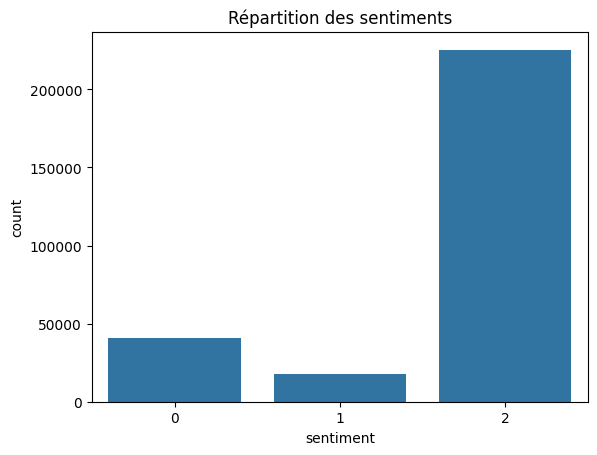

In [165]:
# Visualisation des données
sns.countplot(x='sentiment', data=filter_data)
plt.title('Répartition des sentiments')
plt.show()

In [166]:
# Équilibrage des classes
balanced_samples = []
grouped = filter_data.groupby('sentiment')
for sentiment, group in grouped:
    balanced_sample = group.sample(n=15000, replace=True)
    balanced_samples.append(balanced_sample)

balanced_data = pd.concat(balanced_samples)

In [191]:
print(f"Nombre de lignes : {balanced_data.shape[0]}")
print(f"Nombre de colonnes : {balanced_data.shape[1]}")

Nombre de lignes : 45000
Nombre de colonnes : 4


In [167]:
lemmatizer = WordNetLemmatizer()

In [168]:
def preprocess_text(text):
    # Nettoyage et tokenization
    text = re.sub(r'[^\w\s]', '', text)
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [t.lower() for t in tokens if t.lower() not in stop_words]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return ' '.join(tokens)

In [169]:
balanced_data['processed_comment'] = balanced_data['Comment'].apply(preprocess_text)

In [170]:
# Division en ensembles d'entraînement et de test
X = balanced_data['processed_comment']
y = balanced_data['sentiment']

In [171]:
# Vectorisation des commentaires avec TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X_vectorized = vectorizer.fit_transform(X).toarray()

X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=0.2, random_state=42)

In [172]:
# Modélisation Machine Learning
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [173]:
# Évaluation du modèle ML
rf_predictions = rf_model.predict(X_test)
print("\nRapport de classification (ML) :")
print(classification_report(y_test, rf_predictions))


Rapport de classification (ML) :
              precision    recall  f1-score   support

           0       0.75      0.74      0.75      3006
           1       0.71      0.71      0.71      2988
           2       0.79      0.80      0.80      3006

    accuracy                           0.75      9000
   macro avg       0.75      0.75      0.75      9000
weighted avg       0.75      0.75      0.75      9000



In [174]:
# Étape 6 : Modélisation Deep Learning
input_dim = X_train.shape[1]
dl_model = Sequential([
    Dense(128, input_dim=input_dim, activation='relu'),
    Dropout(0.5), # 0.3 ; 0.4
    Dense(64, activation='relu'),
    # Dense(64, activation='relu'),
    Dense(3, activation='softmax')
])

In [175]:
# Compilation du modèle
from keras.optimizers import Adam
dl_model.compile(optimizer=Adam(learning_rate=0.001), # 0.01, 0.1
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])

In [176]:
# Entraînement du modèle
history = dl_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=2)

Epoch 1/10
1125/1125 - 6s - loss: 0.7528 - accuracy: 0.6571 - val_loss: 0.6717 - val_accuracy: 0.6984 - 6s/epoch - 5ms/step
Epoch 2/10
1125/1125 - 5s - loss: 0.5821 - accuracy: 0.7583 - val_loss: 0.6567 - val_accuracy: 0.7189 - 5s/epoch - 4ms/step
Epoch 3/10
1125/1125 - 5s - loss: 0.4690 - accuracy: 0.8170 - val_loss: 0.6562 - val_accuracy: 0.7344 - 5s/epoch - 4ms/step
Epoch 4/10
1125/1125 - 5s - loss: 0.3621 - accuracy: 0.8691 - val_loss: 0.6895 - val_accuracy: 0.7410 - 5s/epoch - 4ms/step
Epoch 5/10
1125/1125 - 5s - loss: 0.2697 - accuracy: 0.9054 - val_loss: 0.7723 - val_accuracy: 0.7416 - 5s/epoch - 4ms/step
Epoch 6/10
1125/1125 - 5s - loss: 0.2092 - accuracy: 0.9260 - val_loss: 0.8030 - val_accuracy: 0.7482 - 5s/epoch - 4ms/step
Epoch 7/10
1125/1125 - 5s - loss: 0.1701 - accuracy: 0.9409 - val_loss: 0.8847 - val_accuracy: 0.7503 - 5s/epoch - 4ms/step
Epoch 8/10
1125/1125 - 5s - loss: 0.1426 - accuracy: 0.9485 - val_loss: 0.9513 - val_accuracy: 0.7510 - 5s/epoch - 4ms/step
Epoch 9/

In [177]:
# Évaluation du modèle DL
dl_predictions = dl_model.predict(X_test)
dl_predictions_classes = dl_predictions.argmax(axis=1)
print("\nRapport de classification (DL) :")
print(classification_report(y_test, dl_predictions_classes))

282/282 [==============================] - 0s 1ms/step

Rapport de classification (DL) :
              precision    recall  f1-score   support

           0       0.73      0.75      0.74      3006
           1       0.70      0.72      0.71      2988
           2       0.84      0.79      0.81      3006

    accuracy                           0.75      9000
   macro avg       0.75      0.75      0.75      9000
weighted avg       0.75      0.75      0.75      9000



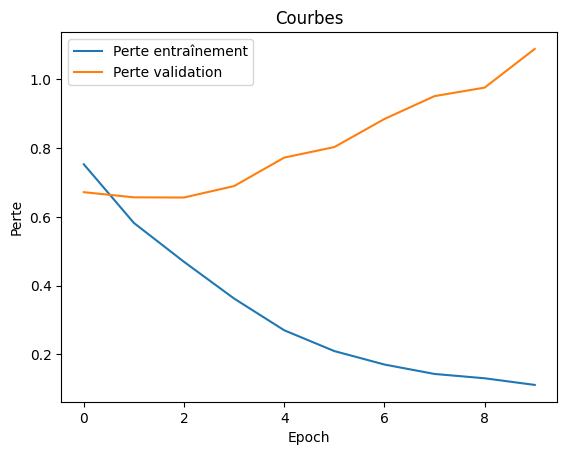

In [178]:
# Analyse de perte
plt.plot(history.history['loss'], label='Perte entraînement')
plt.plot(history.history['val_loss'], label='Perte validation')
plt.title("Courbes")
plt.xlabel("Epoch")
plt.ylabel("Perte")
plt.legend()
plt.show()

In [179]:
initial_distribution = filter_data['sentiment'].value_counts(normalize=True)

balanced_distribution = balanced_data['sentiment'].value_counts(normalize=True)

print("Distribution initiale des classes (en %):")
print((initial_distribution * 100))
print("\nDistribution après équilibrage (en %):")
print((balanced_distribution * 100))

Distribution initiale des classes (en %):
sentiment
2    79.364347
0    14.274546
1     6.361107
Name: proportion, dtype: float64

Distribution après équilibrage (en %):
sentiment
0    33.333333
1    33.333333
2    33.333333
Name: proportion, dtype: float64


In [180]:
# Calcul des statistiques essentielles sur la colonne 'Userscore'
moyenne_score = data['Userscore'].mean()
ecart_type = data['Userscore'].std()
mediane_score = data['Userscore'].median() 

# Affichage des résultats
print(f"Moyenne des scores : {moyenne_score:.2f}")
print(f"Écart-type : {ecart_type:.2f}")
print(f"Médiane : {mediane_score:.2f}")

Moyenne des scores : 7.62
Écart-type : 3.13
Médiane : 9.00


In [183]:
# Récupération d'une ligne aléatoirement
random_index = np.random.randint(0, len(X_test)) 
X_sample = X_test[random_index].reshape(1, -1)
y_sample = y_test.iloc[random_index]

In [184]:
# Prédiction avec ML
ml_prediction = rf_model.predict(X_sample)[0]

# Prédiction avec DL
dl_prediction = dl_model.predict(X_sample).argmax(axis=1)[0]

# Afficher les résultats
print("Label réel :", y_sample)
print("Prédiction ML :", ml_prediction)
print("Prédiction DL :", dl_prediction)

1/1 [==============================] - 0s 19ms/step
Label réel : 1
Prédiction ML : 1
Prédiction DL : 1


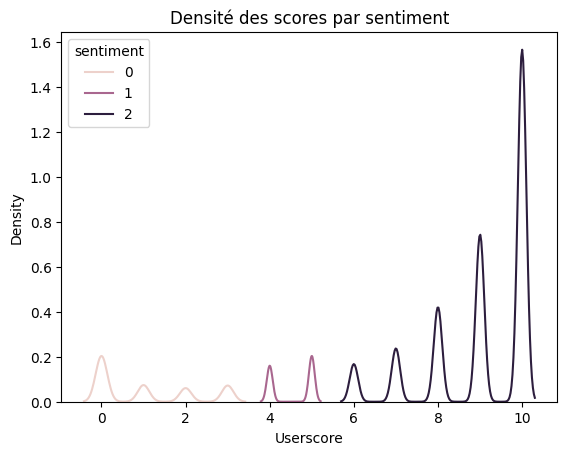

In [185]:
import seaborn as sns
sns.kdeplot(data=filter_data, x='Userscore', hue='sentiment')
plt.title("Densité des scores par sentiment")
plt.show()

In [210]:
# Exemple : afficher les 1000 premiers mots
print("\nPremiers mots du vocabulaire :")
print(vectorizer.get_feature_names_out()[:1000])
# Comme on peut le constater, certains "mot" sont encore à filtre


Premiers mots du vocabulaire :
['010' '06' '09' '10' '100' '1000' '1010' '1015' '1080p' '11' '110' '12'
 '120' '13' '14' '15' '150' '16' '17' '18' '1999' '1st' '20' '200' '2000'
 '2002' '2003' '2004' '2005' '2006' '2007' '2008' '2009' '2010' '2011'
 '2012' '2013' '2014' '2015' '2016' '2017' '2018' '2033' '21' '210' '22'
 '23' '24' '25' '250' '2d' '2k' '2k5' '2nd' '30' '300' '30fps' '310' '32'
 '34' '343' '35' '360' '3d' '3rd' '40' '400' '410' '45' '4k' '4th' '50'
 '500' '5000' '50100' '510' '55' '56' '5th' '60' '60fps' '610' '64' '65'
 '70' '710' '75' '80' '810' '85' '90' '910' '95' '98' '99' 'aa' 'aaa'
 'abandoned' 'ability' 'able' 'abomination' 'absence' 'absent' 'absolute'
 'absolutely' 'absurd' 'abuse' 'abysmal' 'ac' 'ac2' 'ac3' 'accent'
 'accept' 'acceptable' 'access' 'accessible' 'accidentally' 'acclaim'
 'acclaimed' 'accomplish' 'accomplished' 'accomplishment' 'according'
 'account' 'accuracy' 'accurate' 'accurately' 'achieve' 'achieved'
 'achievement' 'acquire' 'across' 'act' 

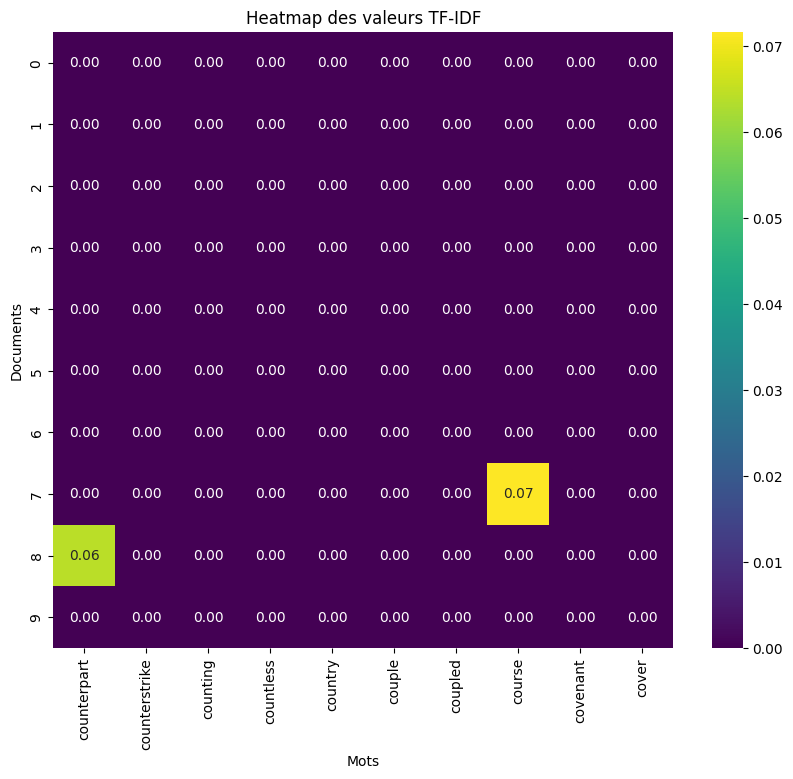

In [219]:
selection = vectorizer.get_feature_names_out()[1000:1010]

# Visualisation par heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(X_vectorized[:10, 1000:1010], annot=True, fmt=".2f", cmap="viridis", xticklabels=selection)
plt.title("Heatmap des valeurs TF-IDF") # échantillon
plt.xlabel("Mots")
plt.ylabel("Documents")
plt.show()